In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from gpcr_mapper.gpcr_mapper import plot_gpcr_mapper
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from utils.roc_functions import plot_roc, plot_precision_recall
from scipy import stats
from statsmodels.formula.api import ols

# Load drug targets

In [2]:
drugs = pd.read_csv('../data/drug_targets/gpcr_drugs.tsv',sep='\t')
drugs = drugs[drugs['year of approval'] != '-']
print('Total drugs:',drugs.shape[0])
print('Drugs by MOA')
print(drugs.moa_simplified.value_counts())

drug_targets_with_moa = drugs.groupby('uniprot_name').moa_simplified.agg(set).reset_index()
drug_targets_with_moa['moa_simplified'] = drug_targets_with_moa['moa_simplified'].apply(lambda x: '&'.join(sorted(x)))
print('Total drug targets:',drug_targets_with_moa.shape[0])

gpcr_genes = pd.read_csv('../data/gene_families/gpcr_genes_human_gpcrdb.tsv', sep = '\t')
gpcr_genes = gpcr_genes[['gene','entry_name','receptor_class','receptor_family','ligand_type']]
gpcr_genes = gpcr_genes.rename(columns = {'entry_name':'uniprot_name'})
gpcr_genes_with_drug_target_moas = gpcr_genes.merge(drug_targets_with_moa, how = 'left', on = 'uniprot_name')
gpcr_genes_with_drug_target_moas['moa_simplified'] = gpcr_genes_with_drug_target_moas['moa_simplified'].fillna('none')

print('Rhodopsin-like drug targets:',gpcr_genes_with_drug_target_moas[
    (gpcr_genes_with_drug_target_moas['receptor_class'] == 'Class A (Rhodopsin)') & \
    (gpcr_genes_with_drug_target_moas.moa_simplified != 'none')].shape[0])
print('Rhodopsin-like drug targets by known MOAs:')
print(gpcr_genes_with_drug_target_moas[
    (gpcr_genes_with_drug_target_moas['receptor_class'] == 'Class A (Rhodopsin)') & \
    (gpcr_genes_with_drug_target_moas.moa_simplified != 'none')
    ].moa_simplified.value_counts())

gpcr_genes_with_drug_target_moas[
    (gpcr_genes_with_drug_target_moas['receptor_class'] == 'Class A (Rhodopsin)')& \
    (gpcr_genes_with_drug_target_moas.moa_simplified != 'none')
].to_csv('../data/drug_targets/rhodopsin_like_gpcr_drug_targets.tsv',sep='\t',index=False)

Total drugs: 968
Drugs by MOA
negative    521
positive    447
Name: moa_simplified, dtype: int64
Total drug targets: 102
Rhodopsin-like drug targets: 89
Rhodopsin-like drug targets by known MOAs:
negative&positive    35
positive             30
negative             24
Name: moa_simplified, dtype: int64


# Load constraint scores

In [13]:
zscores = pd.read_csv('../data/constraint/zscores_hgnc_iuphar.tsv',sep='\t')
zscores = zscores.fillna(0).drop_duplicates('hgnc_symbol')
drug_targets_with_zscores = zscores.merge(gpcr_genes_with_drug_target_moas, how = 'inner', left_on = 'hgnc_symbol',right_on='gene')
drug_targets_with_zscores['z_max'] = drug_targets_with_zscores[['z_lof','z_mis_pphen']].max(axis=1)
classA_drug_targets_with_zscores = drug_targets_with_zscores[
    (drug_targets_with_zscores.receptor_class == 'Class A (Rhodopsin)') 
]


In [10]:
stats.ttest_ind(
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified != 'none'].z_lof,
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified == 'none'].z_lof,
)

Ttest_indResult(statistic=2.747939553318683, pvalue=0.006386507023363831)

In [11]:
stats.ttest_ind(
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified != 'none'].z_mis_pphen,
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified == 'none'].z_mis_pphen,
)

Ttest_indResult(statistic=4.159225285944147, pvalue=4.250759778770144e-05)

In [14]:
stats.ttest_ind(
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified != 'none'].z_max,
    classA_drug_targets_with_zscores[classA_drug_targets_with_zscores.moa_simplified == 'none'].z_max,
)

Ttest_indResult(statistic=4.292587269233559, pvalue=2.436243566356218e-05)

In [13]:
drug_targets_with_zscores[
    (drug_targets_with_zscores.receptor_class == 'Class A (Rhodopsin)') & \
    (drug_targets_with_zscores.moa_simplified != 'none')
    ].mouse_lethal.sum()

21

<Axes: xlabel='moa_simplified', ylabel='z_mis_pphen'>

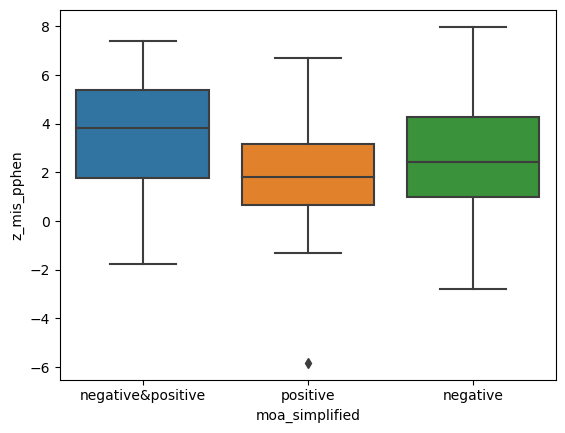

In [7]:
sns.boxplot(data = drug_targets_with_zscores[
    (drug_targets_with_zscores['receptor_class'] == 'Class A (Rhodopsin)')& \
    (drug_targets_with_zscores.moa_simplified != 'none')
], x = 'moa_simplified', y = 'z_mis_pphen')

In [14]:
zscores_by_moa = [drug_targets_with_zscores[
    (drug_targets_with_zscores['receptor_class'] == 'Class A (Rhodopsin)') & \
    (drug_targets_with_zscores.moa_simplified == moa)].z_mis_pphen for moa in ['positive','negative','negative&positive']]

anova = stats.f_oneway(*zscores_by_moa)
print(anova)
result = stats.tukey_hsd(*zscores_by_moa)
print(result)

F_onewayResult(statistic=3.5407087085265148, pvalue=0.033290852801250076)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.800     0.486    -2.460     0.859
 (0 - 2)     -1.678     0.025    -3.186    -0.171
 (1 - 0)      0.800     0.486    -0.859     2.460
 (1 - 2)     -0.878     0.397    -2.484     0.728
 (2 - 0)      1.678     0.025     0.171     3.186
 (2 - 1)      0.878     0.397    -0.728     2.484



In [15]:
zscores_by_moa = [drug_targets_with_zscores[
    (drug_targets_with_zscores['receptor_class'] == 'Class A (Rhodopsin)') & \
    (drug_targets_with_zscores.moa_simplified == moa)].z_lof for moa in ['positive','negative','negative&positive']]

anova = stats.f_oneway(*zscores_by_moa)
print(anova)
result = stats.tukey_hsd(*zscores_by_moa)
print(result)

F_onewayResult(statistic=2.2933001572945946, pvalue=0.10707376625800998)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.657     0.172    -1.522     0.208
 (0 - 2)     -0.620     0.150    -1.406     0.165
 (1 - 0)      0.657     0.172    -0.208     1.522
 (1 - 2)      0.037     0.994    -0.800     0.874
 (2 - 0)      0.620     0.150    -0.165     1.406
 (2 - 1)     -0.037     0.994    -0.874     0.800



In [16]:
zscores_by_moa = [drug_targets_with_zscores[
    (drug_targets_with_zscores['receptor_class'] == 'Class A (Rhodopsin)') & \
    (drug_targets_with_zscores.moa_simplified == moa)].z_max for moa in ['positive','negative','negative&positive']]

anova = stats.f_oneway(*zscores_by_moa)
print(anova)
result = stats.tukey_hsd(*zscores_by_moa)
print(result)

F_onewayResult(statistic=3.6071340526958537, pvalue=0.031310533197854346)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.607     0.574    -2.045     0.830
 (0 - 2)     -1.459     0.025    -2.765    -0.153
 (1 - 0)      0.607     0.574    -0.830     2.045
 (1 - 2)     -0.852     0.315    -2.243     0.539
 (2 - 0)      1.459     0.025     0.153     2.765
 (2 - 1)      0.852     0.315    -0.539     2.243



In [24]:
drug_targets_with_zscores[drug_targets_with_zscores.moa_simplified != 'none'][['hgnc_symbol','z_mis_pphen','z_lof', 'moa_simplified']].sort_values('z_mis_pphen',ascending=False).head(10)

,hgnc_symbol,z_mis_pphen,z_lof,moa_simplified
126,GABBR1,10.788016,6.454341,positive
60,CASR,9.906491,4.498895,positive
127,GABBR2,9.090334,6.374699,positive
80,CHRM4,7.984783,3.359018,negative
84,CNR1,7.395527,2.615616,negative&positive
79,CHRM3,7.376015,4.133707,negative&positive
102,EDNRA,7.368991,4.094441,negative
97,DRD1,7.267810,3.123652,negative&positive
229,HRH2,7.192340,2.122272,negative
78,CHRM2,6.925177,2.372687,negative&positive


In [27]:
drug_targets_with_zscores[drug_targets_with_zscores.moa_simplified != 'none'][['hgnc_symbol','z_mis_pphen','z_lof', 'moa_simplified']].sort_values('z_mis_pphen')

,hgnc_symbol,z_mis_pphen,z_lof,moa_simplified
259,MC1R,-5.823286,-2.389441,positive
134,GIPR,-3.486242,-1.870699,positive
68,CCR5,-2.789517,-1.439281,negative
100,DRD4,-1.782638,-0.779082,negative&positive
300,OPRM1,-1.454064,0.568046,negative&positive
...,...,...,...,...
84,CNR1,7.395527,2.615616,negative&positive
80,CHRM4,7.984783,3.359018,negative
127,GABBR2,9.090334,6.374699,positive
60,CASR,9.906491,4.498895,positive


In [50]:
print(gpcr_genes_with_drug_target_moas[
    (gpcr_genes_with_drug_target_moas['receptor_class'] != 'Class A (Rhodopsin)') & \
    (gpcr_genes_with_drug_target_moas.moa_simplified != 'none')
    ].moa_simplified.value_counts())

positive    11
negative     2
Name: moa_simplified, dtype: int64


In [ ]:
gpcr

In [25]:
drug_targets_with_moa

uniprot_name
5ht1a_human    negative&positive
5ht1b_human    negative&positive
5ht1d_human             positive
5ht1f_human             positive
5ht2a_human    negative&positive
                     ...        
ssr5_human              positive
taar1_human             negative
v1ar_human     negative&positive
v1br_human              positive
v2r_human      negative&positive
Name: moa_simplified, Length: 102, dtype: object

In [20]:
drug_targets_with_moa.apply(lambda x: '&'.join(sorted(x)))

uniprot_name
5ht1a_human    negative&positive
5ht1b_human    negative&positive
5ht1d_human             positive
5ht1f_human             positive
5ht2a_human    negative&positive
                     ...        
ssr5_human              positive
taar1_human             negative
v1ar_human     negative&positive
v1br_human              positive
v2r_human      negative&positive
Name: moa_simplified, Length: 102, dtype: object

In [7]:

print('Total drug targets:',drug_targets_by_moa.shape[0])
print(drug_targets_by_moa.moa_simplified.value_counts())

gpcrs_with_drug_target_status = gpcr_constraint.rename(columns = {'entry_name':'uniprot_name'}).merge(drug_targets_by_moa,how='left')
gpcrs_with_drug_target_status['moa_simplified'] = gpcrs_with_drug_target_status.moa_simplified.fillna('none')
print('Total drug targets matched:',(gpcrs_with_drug_target_status.moa_simplified != 'none').sum())

classA_gpcrs_with_drug_target_status = gpcrs_with_drug_target_status[gpcrs_with_drug_target_status.receptor_class == 'Class A (Rhodopsin)']
print('Class A matched:',(classA_gpcrs_with_drug_target_status.moa_simplified != 'none').sum())

FileNotFoundError: [Errno 2] No such file or directory: '../data/labels/drug_targets/gpcr_drugs_approved_w_gene.tsv'

In [5]:
gpcr_gene_lookup = gpcrs[['entry_name','gene']].rename(columns = {'entry_name':'uniprot_name'})
drugs.merge(gpcr_gene_lookup).to_csv('../data/labels/drug_targets/gpcr_drugs_approved_w_gene.tsv',sep='\t')

In [16]:
top_25 = classA_gpcrs_with_drug_target_status.sort_values('z_max',ascending=False).head(25)
print(top_25.moa_simplified.value_counts())
print(top_25.z_max.describe())

negative_positive    12
none                  7
negative              3
positive              3
Name: moa_simplified, dtype: int64
count    25.000000
mean      6.277599
std       0.828536
min       5.179416
25%       5.542169
50%       6.203402
75%       6.925177
max       7.984783
Name: z_max, dtype: float64


In [6]:
x1 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified!='none'].z_lof
x2 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='none'].z_lof
print(ttest_ind(x1, x2))


x1 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified!='none'].z_max
x2 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='none'].z_max
print(ttest_ind(x1, x2))

x1 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='positive'].z_lof
x2 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='negative'].z_lof
x3 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='positive_negative'].z_lof
print(ttest_ind(x1, x2))
print(ttest_ind(x1, x3))
print(ttest_ind(x2, x3))

x1 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='positive'].z_max
x2 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='negative'].z_max
x3 = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified=='positive_negative'].z_max
print(ttest_ind(x1, x2))
print(ttest_ind(x1, x3))
print(ttest_ind(x2, x3))

Ttest_indResult(statistic=2.6565750619706536, pvalue=0.008346821522278385)
Ttest_indResult(statistic=4.2169567514903985, pvalue=3.346243563309299e-05)
Ttest_indResult(statistic=-1.7288565275103234, pvalue=0.08965655816893489)
Ttest_indResult(statistic=-1.6928120771530657, pvalue=0.09551096770865224)
Ttest_indResult(statistic=0.12853825395780744, pvalue=0.8981754886563442)
Ttest_indResult(statistic=-1.0158921516186215, pvalue=0.3142960336691501)
Ttest_indResult(statistic=-2.613521972265615, pvalue=0.011232310098832696)
Ttest_indResult(statistic=-1.3456198428184187, pvalue=0.18375358312831064)


In [19]:
classA_gpcrs_with_drug_target_status =  drug_targets_with_zscores[drug_targets_with_zscores.receptor_class == 'Class A (Rhodopsin)']
classA_gpcrs_with_drug_target_status['z_max'] = classA_gpcrs_with_drug_target_status[['z_lof','z_mis_pphen']].max(axis=1)

/tmp/ipykernel_717/1408750548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classA_gpcrs_with_drug_target_status['z_max'] = classA_gpcrs_with_drug_target_status[['z_lof','z_mis_pphen']].max(axis=1)


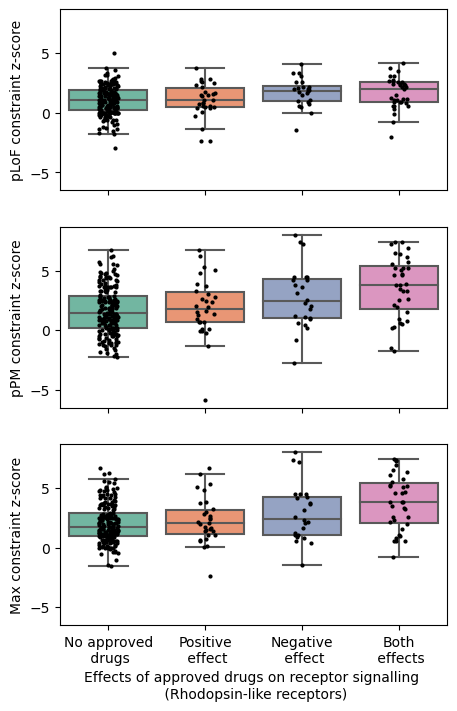

In [24]:
sns.set_palette('Set2')
fig, ax = plt.subplots(3,1, figsize = (5, 8),sharex=True, sharey=True)
order = ['none','positive','negative','negative&positive']
xlabels = ['No approved\n drugs','Positive\n effect','Negative\n effect','Both\n effects']
sns.stripplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_lof',
    ax = ax[0], linewidth=1,edgecolor='gray', order = order, color='k', s= 2
)
sns.boxplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_lof',
    ax = ax[0], fliersize=0,order=order
)
ax[0].set_xticks(ax[0].get_xticks(),xlabels)
ax[0].set_ylabel('pLoF constraint z-score')
ax[0].set_xlabel('')
sns.stripplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_mis_pphen',
    ax = ax[1], linewidth=1,edgecolor='gray', order = order, color='k', s= 2
)
sns.boxplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_mis_pphen',
    ax = ax[1], fliersize=0,order=order
)
ax[1].set_xticks(ax[1].get_xticks(),xlabels)
ax[1].set_ylabel('pPM constraint z-score')
ax[1].set_xlabel('')

sns.stripplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_max',
    ax = ax[2], linewidth=1,edgecolor='gray', order = order, color='k', s= 2
)
sns.boxplot(
    data = classA_gpcrs_with_drug_target_status,
    x = 'moa_simplified',
    y = 'z_max',
    ax = ax[2], fliersize=0,order=order
)
ax[2].set_xticks(ax[2].get_xticks(),xlabels)
ax[2].set_ylabel('Max constraint z-score')
ax[2].set_xlabel('')

ax[2].set_xlabel('Effects of approved drugs on receptor signalling \n (Rhodopsin-like receptors)')
plt.savefig('../plots/Fig4CD_drug_targets_boxplots.png',dpi=450)

In [30]:
zscores['z_max'] = np.maximum(zscores.z_lof,zscores.z_mis_pphen)

In [38]:
top_quintile = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.z_max>zscores.z_max.quantile(0.8)]
print(top_quintile.shape[0])
print(top_quintile.moa_simplified.value_counts()) #/ top_quintile.shape[0])
print((top_quintile.moa_simplified!='none').mean())

24
negative&positive    11
none                  7
negative              3
positive              3
Name: moa_simplified, dtype: int64
0.7083333333333334


In [36]:
top_quintile = classA_gpcrs_with_drug_target_status[(classA_gpcrs_with_drug_target_status.z_mis_pphen>zscores.z_mis_pphen.quantile(0.8)) | \
    (classA_gpcrs_with_drug_target_status.z_lof>zscores.z_lof.quantile(0.8))
                                                    ]
print(top_quintile.shape[0])
print(top_quintile.moa_simplified.value_counts() / top_quintile.shape[0])

36
none                 0.416667
negative&positive    0.361111
positive             0.138889
negative             0.083333
Name: moa_simplified, dtype: float64


aminergic receptors: 34  out of  36
mean pPM z-score 3.673855145728781
peptide receptors: 25  out of  75
mean pPM z-score 1.8982592705778603


Ttest_indResult(statistic=2.58254891791507, pvalue=0.012399860875103759)

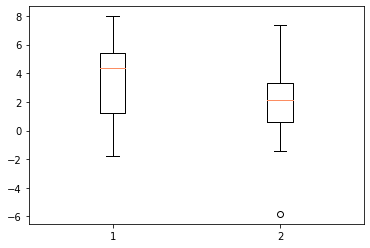

In [65]:
gpcr_approved_drug_targets = classA_gpcrs_with_drug_target_status[classA_gpcrs_with_drug_target_status.moa_simplified!='none']

with open('../data/labels/gene_families/aminergic_receptor_genes.txt','r') as fid:
    aminergic_receptors = [line.rstrip() for line in fid]
aminergic_receptor_drug_targets = list(gpcr_approved_drug_targets[gpcr_approved_drug_targets.gene.isin(aminergic_receptors)].gene)
aminergic_receptor_drug_target_constraint = list(gpcr_approved_drug_targets[gpcr_approved_drug_targets.gene.isin(aminergic_receptors)].z_mis_pphen)

with open('../data/labels/gene_families/peptide_receptor_genes.txt','r') as fid:
    peptide_receptors = [line.rstrip() for line in fid]
peptide_receptor_drug_targets = list(gpcr_approved_drug_targets[gpcr_approved_drug_targets.gene.isin(peptide_receptors)].gene)
peptide_receptor_drug_target_constraint = list(gpcr_approved_drug_targets[gpcr_approved_drug_targets.gene.isin(peptide_receptors)].z_mis_pphen)


print('aminergic receptors:', len(aminergic_receptor_drug_targets),' out of ', len(aminergic_receptors))
print('mean pPM z-score',np.mean(aminergic_receptor_drug_target_constraint))
print('peptide receptors:', len(peptide_receptor_drug_targets),' out of ', len(peptide_receptors))
print('mean pPM z-score',np.mean(peptide_receptor_drug_target_constraint))
plt.boxplot(x=[aminergic_receptor_drug_target_constraint,peptide_receptor_drug_target_constraint])
ttest_ind(aminergic_receptor_drug_target_constraint, peptide_receptor_drug_target_constraint)

N = 90
P = 0.3191489361702128
0.61
0.64
0.63
0.43546
0.52315
0.51739


Text(0, 0.5, 'Precision (GPCR drug target genes)')

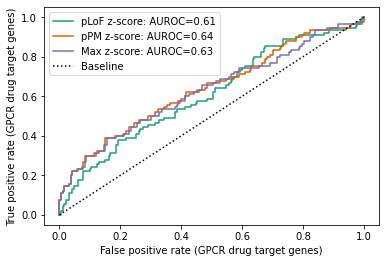

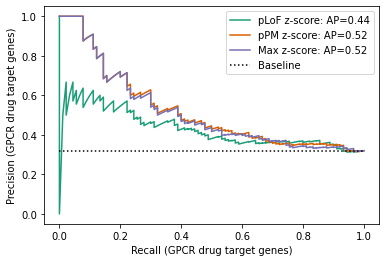

In [13]:
y = classA_gpcrs_with_drug_target_status.moa_simplified!='none'
print('N =', y.sum())
print('P =', y.mean())


sns.set_palette('Dark2')
for metric, label in zip(['z_lof','z_mis_pphen','z_max'], ['pLoF z-score','pPM z-score','Max z-score']):
    x = classA_gpcrs_with_drug_target_status[metric].values
    auroc = plot_roc(y, x, ax= None, label=label)
    print(round(auroc,2))

plt.plot((0, 1), color='k',linestyle='dotted',label='Baseline')
plt.xlabel('False positive rate (GPCR drug target genes)')
plt.ylabel('True positive rate (GPCR drug target genes)')

plt.legend()
#plt.savefig('../plots/Fig4C_classA_gpcr_drug_target_roc.png', dpi=450)

plt.subplots()
for metric, label in zip(['z_lof','z_mis_pphen','z_max'], ['pLoF z-score','pPM z-score','Max z-score']):
    x = classA_gpcrs_with_drug_target_status[metric].values
    ap = plot_precision_recall(y, x, label = label)
    print(round(ap,5))

plt.hlines(y.mean(), 0, 1, color='k', linestyle='dotted', label = 'Baseline')
#plt.ylim((0,0.02))
plt.legend()
plt.xlabel('Recall (GPCR drug target genes)')
plt.ylabel('Precision (GPCR drug target genes)')
#plt.yticks(np.linspace(0, 0.02, 5))

#plt.savefig('../plots/Fig4D_classA_gpcr_drug_target_prc.png', dpi=450,layout='tight')

N = 60
P = 0.2127659574468085
0.65
0.68
0.67
0.34692
0.46095
0.45519


Text(0, 0.5, 'Precision (GPCR drug target genes)')

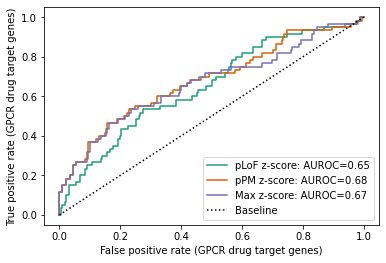

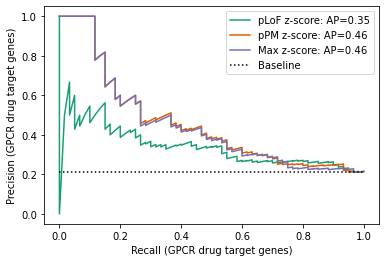

In [14]:
y = classA_gpcrs_with_drug_target_status.moa_simplified.isin(['negative','negative_positive'])
print('N =', y.sum())
print('P =', y.mean())


sns.set_palette('Dark2')
for metric, label in zip(['z_lof','z_mis_pphen','z_max'], ['pLoF z-score','pPM z-score','Max z-score']):
    x = classA_gpcrs_with_drug_target_status[metric].values
    auroc = plot_roc(y, x, ax= None, label=label)
    print(round(auroc,2))

plt.plot((0, 1), color='k',linestyle='dotted',label='Baseline')
plt.xlabel('False positive rate (GPCR drug target genes)')
plt.ylabel('True positive rate (GPCR drug target genes)')

plt.legend()
#plt.savefig('../plots/Fig4C_classA_gpcr_drug_target_roc.png', dpi=450)

plt.subplots()
for metric, label in zip(['z_lof','z_mis_pphen','z_max'], ['pLoF z-score','pPM z-score','Max z-score']):
    x = classA_gpcrs_with_drug_target_status[metric].values
    ap = plot_precision_recall(y, x, label = label)
    print(round(ap,5))

plt.hlines(y.mean(), 0, 1, color='k', linestyle='dotted', label = 'Baseline')
#plt.ylim((0,0.02))
plt.legend()
plt.xlabel('Recall (GPCR drug target genes)')
plt.ylabel('Precision (GPCR drug target genes)')
#plt.yticks(np.linspace(0, 0.02, 5))

#plt.savefig('../plots/Fig4D_classA_gpcr_drug_target_prc.png', dpi=450,layout='tight')

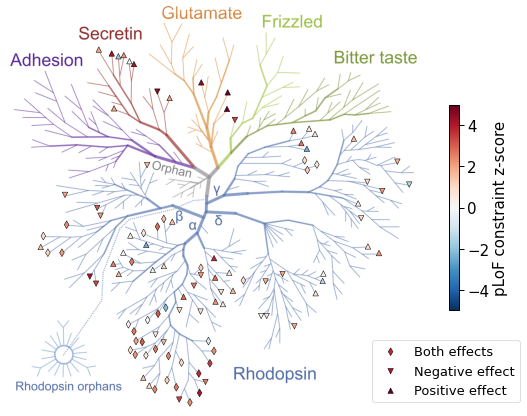

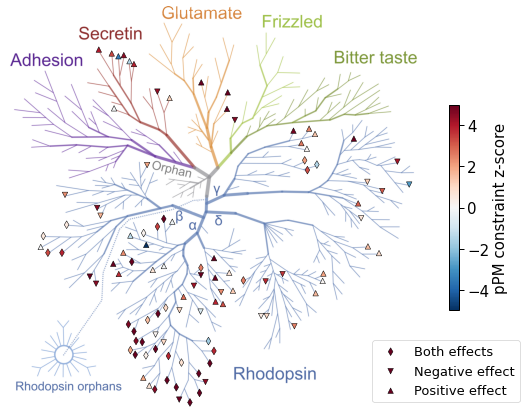

In [72]:
mappings = pd.read_csv('gpcr_mapper/gpcr_treemapper_coords.txt',sep='\t')
df = gpcrs_with_drug_target_status[gpcrs_with_drug_target_status.moa_simplified!='none'].merge(mappings)
df['moa_simplified'] = df.moa_simplified.map(
    dict(zip(
        ['positive','negative','positive_negative'],
        ['Positive effect','Negative effect','Both effects']
    ))
)
sns.set_context('paper')

ax = plot_gpcr_mapper(
    df.x, 
    df.y, 
    df['z_lof'], 
    df.moa_simplified,
    'pLoF constraint z-score',
    markers=['d','v','^'],
    cmap='RdBu_r',
    cbar_shrink=0.5,
    cscale=(-5, 5),
    marker_size = 30
    )
plt.legend(loc='lower right',bbox_to_anchor= (1.25, 0),prop={'size':13})
plt.tight_layout()
plt.savefig('../plots/Fig4A_GPCR_mapper_drug_targets_z_lof.png',dpi=450)

ax = plot_gpcr_mapper(
    df.x, 
    df.y, 
    df['z_mis_pphen'], 
    df.moa_simplified,
    'pPM constraint z-score',
    markers=['d','v','^'],
    cmap='RdBu_r',
    cbar_shrink=0.5,
    cscale=(-5, 5),
    marker_size=30
    )
plt.tight_layout()

plt.legend(loc='lower right',bbox_to_anchor= (1.25, 0),prop={'size':13})
plt.savefig('../plots/Fig4B_GPCR_mapper_drug_targets_z_mis_pphen.png',dpi=450)

0.19838611449451887


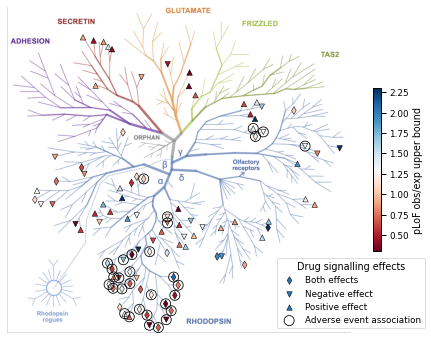

In [22]:
constraint = pd.read_csv("../data/constraint/gnomad/all_genes_constraint_exact_a0.1.tsv", sep = '\t', index_col=0)

rankscale_oeuf = lambda x: 1-x.rank(pct=True).fillna(1)
constraint['oeuf_lof_rank'] = rankscale_oeuf(constraint['oeuf_lof'])
constraint['oeuf_mis_pphen_rank'] = rankscale_oeuf(constraint['oeuf_mis_pphen'])
constraint['oeuf_mean_rank'] = (constraint.oeuf_lof_rank + constraint.oeuf_mis_pphen_rank) / 2

gnomad_mouse_essentials = pd.read_csv('../data/labels/mouse_essential_genes/gnomad_mouse_essential_genes_hom.tsv',sep='\t', header=None)[0]
constraint['mouse_essential'] = constraint.gene.isin(gnomad_mouse_essentials)

print(constraint.mouse_essential.mean())


gpcrs = pd.read_csv('../data/labels/gpcr_genes_human_gpcrdb.tsv', sep = '\t')
constraint = constraint.rename(columns = {'gene':'gene_gnomad'})
constraint_gpcrs = constraint.merge(gpcrs, on='gene_gnomad')

drug_targets = pd.read_csv('../data/labels/drug_targets/gpcr_drug_targets_approved.tsv',sep='\t')
drug_targets = drug_targets.rename(columns={'symbol':'gene'})
drug_target_genes = constraint_gpcrs.merge(drug_targets,on='gene')
df = drug_target_genes[drug_target_genes.approved_drugs_level != 'none'].copy()
df['approved_drugs_level'] = df.approved_drugs_level.map(
    {
        'antagonistic_and_agonistic':'Both effects',
        'agonistic':'Positive effect',
        'antagonistic':'Negative effect'
    }
)
mappings = pd.read_csv('gpcr_mapper/gpcr_treemapper_coords.txt',sep='\t')
df = df.merge(mappings)



# GPCR drug targets

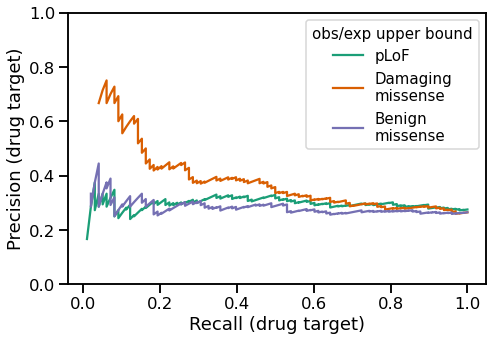

In [5]:

phenotyped_genes = pd.read_csv('../data/constraint/gpcrs_with_constraint_and_phenotypes.tsv',index_col=0,sep='\t')

drug_targets = pd.read_csv('../data/drug_targets/gpcr_drug_targets.tsv',sep='\t')
drug_target_genes = phenotyped_genes.merge(drug_targets,on='symbol')



def plot_precision_recall(y_true, y_pred, label='', color='k'):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avprc = average_precision_score(y_true,y_pred)
    plt.plot(recall[:-6], precision[:-6], label = label, color= color)# + f': AP={avprc:.2f}',color=color)


y_true = drug_target_genes.approved_drugs_level != 'none'

metrics = ['oeuf|lof', 'oeuf|mis_pphen','oeuf|mis_non_pphen']


labels = ['pLoF', 'Damaging\nmissense','Benign\nmissense']
colors = [plt.get_cmap("Dark2")(i) for i in range(3)]

sns.set_context('talk')
plt.subplots(figsize = (7.5,5))

#plot_precision_recall(y_true, -gpcrs_constraint[['oeuf|lof', 'oeuf|mis_pphen']].rank(pct=True).fillna(1).mean(axis=1), 'Mean_rank')
for metric, label, color in zip(metrics,labels,colors):
    plot_precision_recall(y_true, -drug_target_genes[metric].rank(pct=True).fillna(1),label=label, color = color)

plt.ylim((0,1))
plt.legend(title= 'obs/exp upper bound',fontsize = 15,title_fontsize=15)
plt.ylabel('Precision (drug target)')
plt.xlabel('Recall (drug target)')
plt.savefig('../plots/prc_all_gpcrs_drug_targets.png',bbox_inches='tight',dpi=500)

pLoF 0.4449464919323898
Damaging
missense 0.45827758171495925
Benign
missense 0.322453425149974


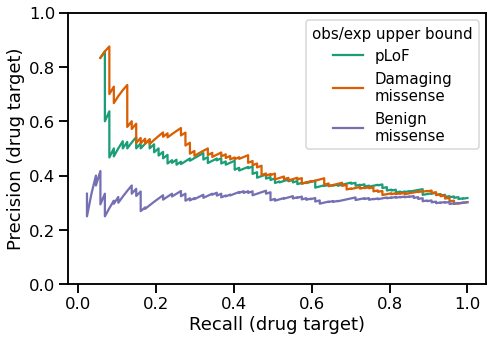

In [7]:

phenotyped_genes = pd.read_csv('../data/constraint/gpcrs_with_constraint_and_phenotypes.tsv',index_col=0,sep='\t')

drug_targets = pd.read_csv('../data/drug_targets/gpcr_drug_targets.tsv',sep='\t')
drug_target_genes = phenotyped_genes.merge(drug_targets,on='symbol')

drug_target_genes = drug_target_genes[drug_target_genes.class_x == 'A']


def plot_precision_recall(y_true, y_pred, label='', color='k'):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avprc = average_precision_score(y_true,y_pred)
    print(label, avprc)
    plt.plot(recall[:-6], precision[:-6], label = label, color= color)# + f': AP={avprc:.2f}',color=color)


y_true = drug_target_genes.approved_drugs_level != 'none'

metrics = ['oeuf|lof', 'oeuf|mis_pphen','oeuf|mis_non_pphen']


labels = ['pLoF', 'Damaging\nmissense','Benign\nmissense']
colors = [plt.get_cmap("Dark2")(i) for i in range(3)]

sns.set_context('talk')
plt.subplots(figsize = (7.5,5))

#plot_precision_recall(y_true, -gpcrs_constraint[['oeuf|lof', 'oeuf|mis_pphen']].rank(pct=True).fillna(1).mean(axis=1), 'Mean_rank')
for metric, label, color in zip(metrics,labels,colors):
    plot_precision_recall(y_true, -drug_target_genes[metric].rank(pct=True).fillna(1),label=label, color = color)

plt.ylim((0,1))
plt.legend(title= 'obs/exp upper bound',fontsize = 15,title_fontsize=15)
plt.ylabel('Precision (drug target)')
plt.xlabel('Recall (drug target)')
plt.savefig('../plots/prc_all_gpcrs_drug_targets.png',bbox_inches='tight',dpi=500)

# Drug indications

488
373
SpearmanrResult(correlation=0.22788902035891948, pvalue=0.027170642069995008)


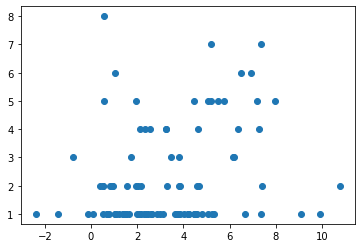

In [ ]:
drug_atcs = pd.read_csv('../data/labels/drug_targets/drug_annotations/ATC_cleaned.csv',index_col=0)
atcs = drug_atcs.ATC_code_level_1.unique()
print(len(drugs.drug_name.unique()))
drugs_with_atcs = drug_atcs.rename(columns={'Label_name':'drug_name'}).merge(drugs)
print(len(drugs_with_atcs.drug_name.unique()))
drug_targets_by_indication = drugs_with_atcs.groupby('uniprot_name').ATC_code_level_1.agg(lambda x: list(set(x))).reset_index()
drug_targets_by_indication['exists'] = 1
drug_targets_by_indication = drug_targets_by_indication.explode('ATC_code_level_1')
drug_targets_by_indication = drug_targets_by_indication.pivot(index='uniprot_name',columns='ATC_code_level_1',values = 'exists').reset_index()
drug_targets_by_indication['is_drug_target'] = 1
gpcr_constraint_by_indication = gpcr_constraint.rename(columns = {'entry_name':'uniprot_name'}).merge(drug_targets_by_indication,how='left').fillna(0)
gpcr_constraint_by_indication

df = gpcr_constraint.rename(columns = {'entry_name':'uniprot_name'}).merge(drugs_with_atcs.groupby('uniprot_name').ATC_code_level_1.agg(lambda x: len(list(set(x)))).reset_index())[['gene','z_max','z_lof','ATC_code_level_1']].sort_values('z_max')
plt.scatter(df.z_max, df.ATC_code_level_1)
print(spearmanr(df.z_max, df.ATC_code_level_1))
df.to_csv('../data/labels/drug_targets/gpcr_drug_targets_by_constraint_and_ATC.tsv',sep='\t')
df = gpcr_constraint_by_indication

for atc in atcs:
    if atc in df.columns:
        print(atc, 'n = ', len(df[df[atc]==1].gene))
        print('relative to all GPCR genes', ttest_ind(df[df[atc]==1].z_max, df[df[atc]==0].z_max))
        print('relative to GPCR drug target genes', ttest_ind(df[df[atc]==1].z_max, df[(df[atc]==0) & (df.is_drug_target==1)].z_max))
        plt.subplots()
        sns.stripplot(data = df, x = atc, y = 'z_max')

# GPCR drug target adverse events

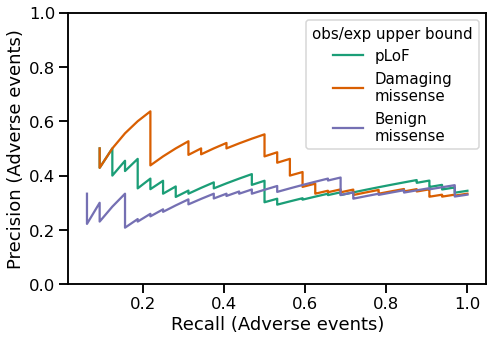

In [ ]:
drug_targets = pd.read_csv('../data/gene_lists/gpcr_drug_targets.tsv',sep='\t')
drug_target_genes = phenotyped_genes.merge(drug_targets,on='symbol')
drug_target_genes = drug_target_genes[
    (drug_target_genes.approved_drugs_level != 'none') 
 ] #&
  #  (drug_target_genes.class_x == 'A')]
y_true = drug_target_genes.adverse_event_associations == 'Yes'
metrics = ['oeuf|lof', 'oeuf|mis_pphen','oeuf|mis_non_pphen']


labels = ['pLoF', 'Damaging\nmissense','Benign\nmissense']
colors = [plt.get_cmap("Dark2")(i) for i in range(3)]

sns.set_context('talk')
plt.subplots(figsize = (7.5,5))

#plot_precision_recall(y_true, -gpcrs_constraint[['oeuf|lof', 'oeuf|mis_pphen']].rank(pct=True).fillna(1).mean(axis=1), 'Mean_rank')
for metric, label, color in zip(metrics,labels,colors):
    plot_precision_recall(y_true, -drug_target_genes[metric].rank(pct=True).fillna(1),label=label, color = color)

plt.ylim((0,1))
plt.legend(title= 'obs/exp upper bound',fontsize = 15,title_fontsize=15)
plt.ylabel('Precision (Adverse events)')
plt.xlabel('Recall (Adverse events)')
plt.savefig('../plots/prc_all_gpcrs_drug_targets_safeties.png',bbox_inches='tight',dpi=500)